In [ ]:
import os
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, TimestampType
from pyspark.sql.functions import col, current_timestamp, to_date, hour, dayofweek

import numpy as np

from itertools import combinations

In [4]:
def create_new_spark_context(appName):
    return SparkSession.builder.appName(appName)\
        .master("local[*]").getOrCreate()


spark_session = create_new_spark_context("LSH")
sc = spark_session.sparkContext


In [5]:
schema = StructType([
    StructField("DEVICE_CODE", IntegerType(), True),
    StructField("SYSTEM_ID", IntegerType(), True),
    StructField("ORIGINE_CAR_KEY", StringType(), True),
    StructField("FINAL_CAR_KEY", StringType(), True),
    StructField("CHECK_STATUS_KEY", IntegerType(), True),
    StructField("COMPANY_ID", StringType(), True),
    StructField("PASS_DAY_TIME", TimestampType(), True)
])

In [67]:
df = spark_session.read.csv(
    '/content/drive/MyDrive/MDA/Project/TrafficData.csv', header=True, schema=schema)


First we remove the outliers from the data. Namely the cars that have been recorded more than 1000 times. We can do this by using the following code:

In [68]:
# add count column to count the number of records, group by FINAL_CAR_KEY
# define a window to count the number of records for each car

from pyspark.sql.window import Window
from pyspark.sql.functions import count

window = Window.partitionBy("FINAL_CAR_KEY")
df = df.withColumn("COUNT", count("*").over(window))

# remove cars with moe than 1000 records
df = df.filter(col("COUNT") < 1000)
df.show(5)


+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|DEVICE_CODE|SYSTEM_ID|ORIGINE_CAR_KEY|FINAL_CAR_KEY|CHECK_STATUS_KEY|COMPANY_ID|      PASS_DAY_TIME|COUNT|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
|   22010053|      284|       10000007|     10000007|               5|       161|2022-01-12 06:30:27|    1|
|     900233|      283|       10000016|     10000016|               5|       264|2022-01-14 13:57:13|    1|
|     900242|      283|       10000048|     10000048|               5|       264|2022-01-09 21:58:56|    9|
|     101301|       81|       10000048|     10000048|               5|       161|2022-01-09 21:54:31|    9|
|        135|       81|       10000048|     10000048|               5|       161|2022-01-09 21:36:46|    9|
+-----------+---------+---------------+-------------+----------------+----------+-------------------+-----+
only showing top 5 rows



## HITS Algorithm

In [69]:
# add column TIME with the hour of the week
df = df.withColumn("TIME", hour("PASS_DAY_TIME") + (dayofweek("PASS_DAY_TIME") - 1) * 24)

In [70]:
# select DEVICE_CODE, FINAL_CAR_KEY, TIME
df = df.select("DEVICE_CODE", "FINAL_CAR_KEY", "TIME")

# convert to spark rdd
rdd = df.rdd

# get number of records grouped by (DEVICE_CODE, TIME)
rdd = rdd.map(lambda x: ((x[0], x[2]), 1)).reduceByKey(lambda x, y: x + y)

Now We Create a matrix, entry of which is the number of times a device has recorded a car at a given time. We use the following code:

In [72]:
# create matrix with rows as devices and columns as hours of the week, and values as number of records
# we can build the matrix using CoordinateMatrix from pyspark.mllib.linalg.distributed

from pyspark.mllib.linalg.distributed import CoordinateMatrix, MatrixEntry

matrix_rdd = rdd.map(lambda x: MatrixEntry(x[0][0], x[0][1], x[1]))
device_time_matrix = CoordinateMatrix(matrix_rdd)
device_time_matrix.entries.take(5)

[MatrixEntry(900242, 108, 1121.0),
 MatrixEntry(100701303, 108, 941.0),
 MatrixEntry(200301, 103, 180.0),
 MatrixEntry(900222, 13, 3710.0),
 MatrixEntry(631608, 80, 463.0)]

To find the authority and hub scores, we can perform an SVD on the matrix. By Doing this we can find the top 10 devices with the highest authority and hub scores. In other words, we can find the top 10 devices that are most likely to be the source of the traffic and the top 10 devices that are most likely to be the destination of the traffic. This top 10 devices are in fact the top 10 largest eigenvalues computed by the SVD. We use the following code:

In [73]:
# first we perform svd on the computed matrix
svd = device_time_matrix.toRowMatrix().computeSVD(10, computeU=True)

# get U, S, V
U = svd.U
S = svd.s
V = svd.V

Now we get the top 10 devices with the highest authority and hub scores. Their scores are entries of U and V. We use the following code:

In [74]:
hubs = U.rows.map(lambda row: -row.toArray()[0]).collect()
authorities = -V.toArray()[:, 0]

print(f'Number of hubs: {len(hubs)}')
print(f'Number of authorities: {len(authorities)}')

# print score of the top 10 hubs and authorities
print(f'Top 10 hubs: {sorted(hubs, reverse=True)[:10]}')
print(f'Top 10 authorities: {sorted(authorities, reverse=True)[:10]}')

Number of hubs: 946
Number of authorities: 168
Top 10 hubs: [0.2531169699664147, 0.2524813941564994, 0.22036848099587503, 0.2137319988798504, 0.19965607571934782, 0.19566547221941127, 0.17116661047197296, 0.16943379209686557, 0.15944431135849144, 0.14907343581264584]
Top 10 authorities: [0.12407527218445596, 0.12124680844300346, 0.11680380787310192, 0.11475483280008751, 0.11381677461287641, 0.11100033960926878, 0.11038238061469038, 0.10784539885805848, 0.10593109102020785, 0.10563438686629788]


### Plotting the results

Now we plot the results. For each time of the week, which is an authority, we plot the authority score of each one. We use the following code:

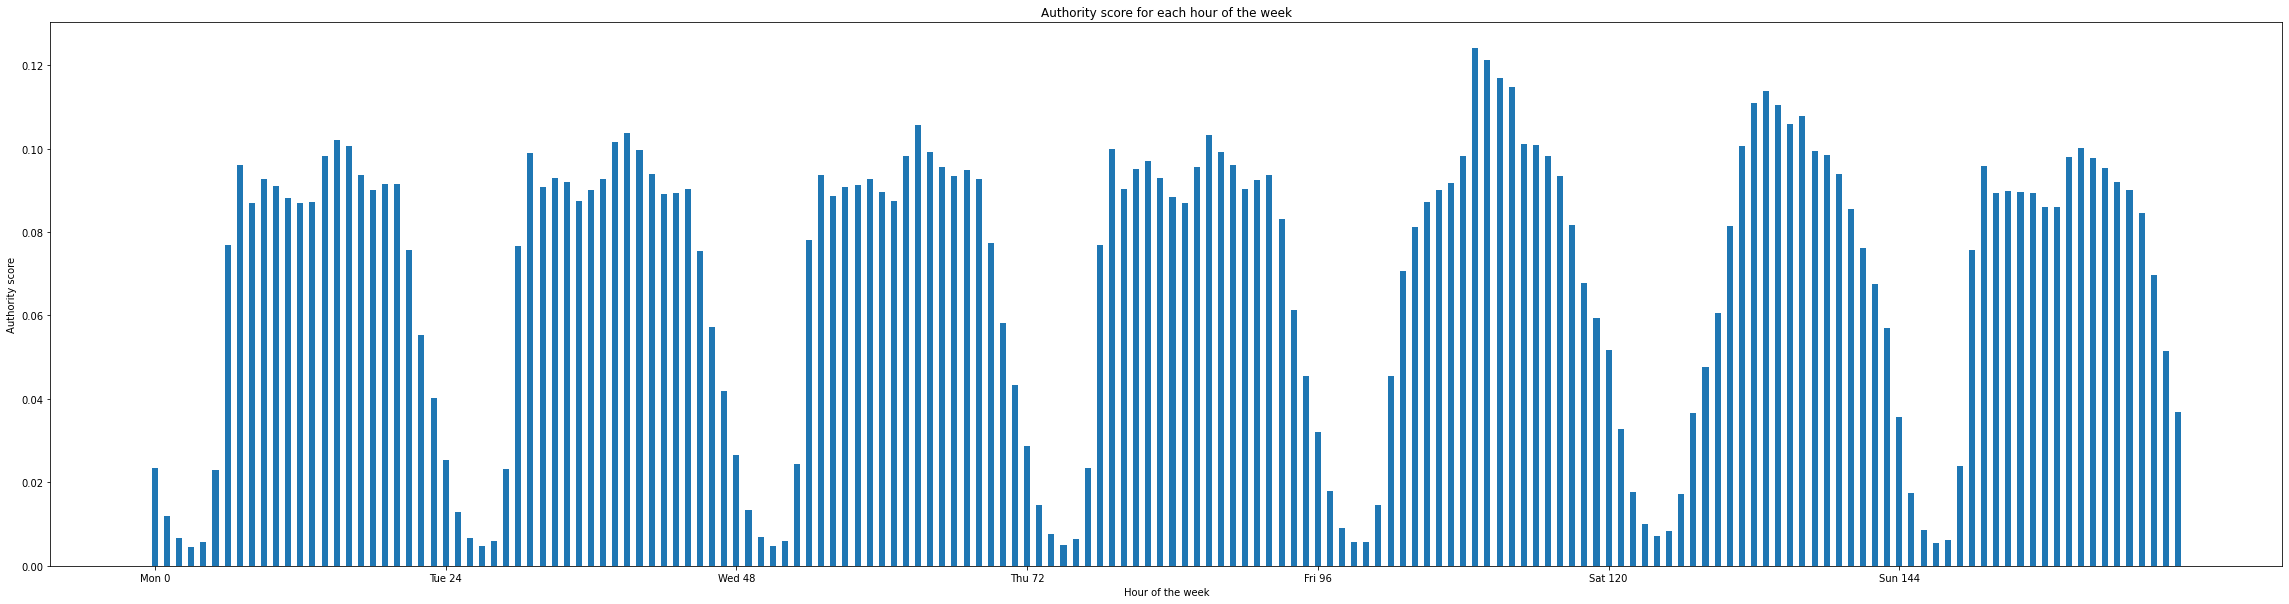

In [75]:
# plot authority scores

import matplotlib.pyplot as plt

plt.figure(figsize=(40, 10))
 

plt.bar(np.arange(168), authorities, width=0.5)
plt.xticks(np.arange(0, 168, 24), ['Mon 0', 'Tue 24', 'Wed 48', 'Thu 72', 'Fri 96', 'Sat 120', 'Sun 144'])
plt.xlabel('Hour of the week')
plt.ylabel('Authority score')
plt.title('Authority score for each hour of the week')
plt.show()

In [76]:
hubs = np.array(hubs)
np.argmax(hubs)

541

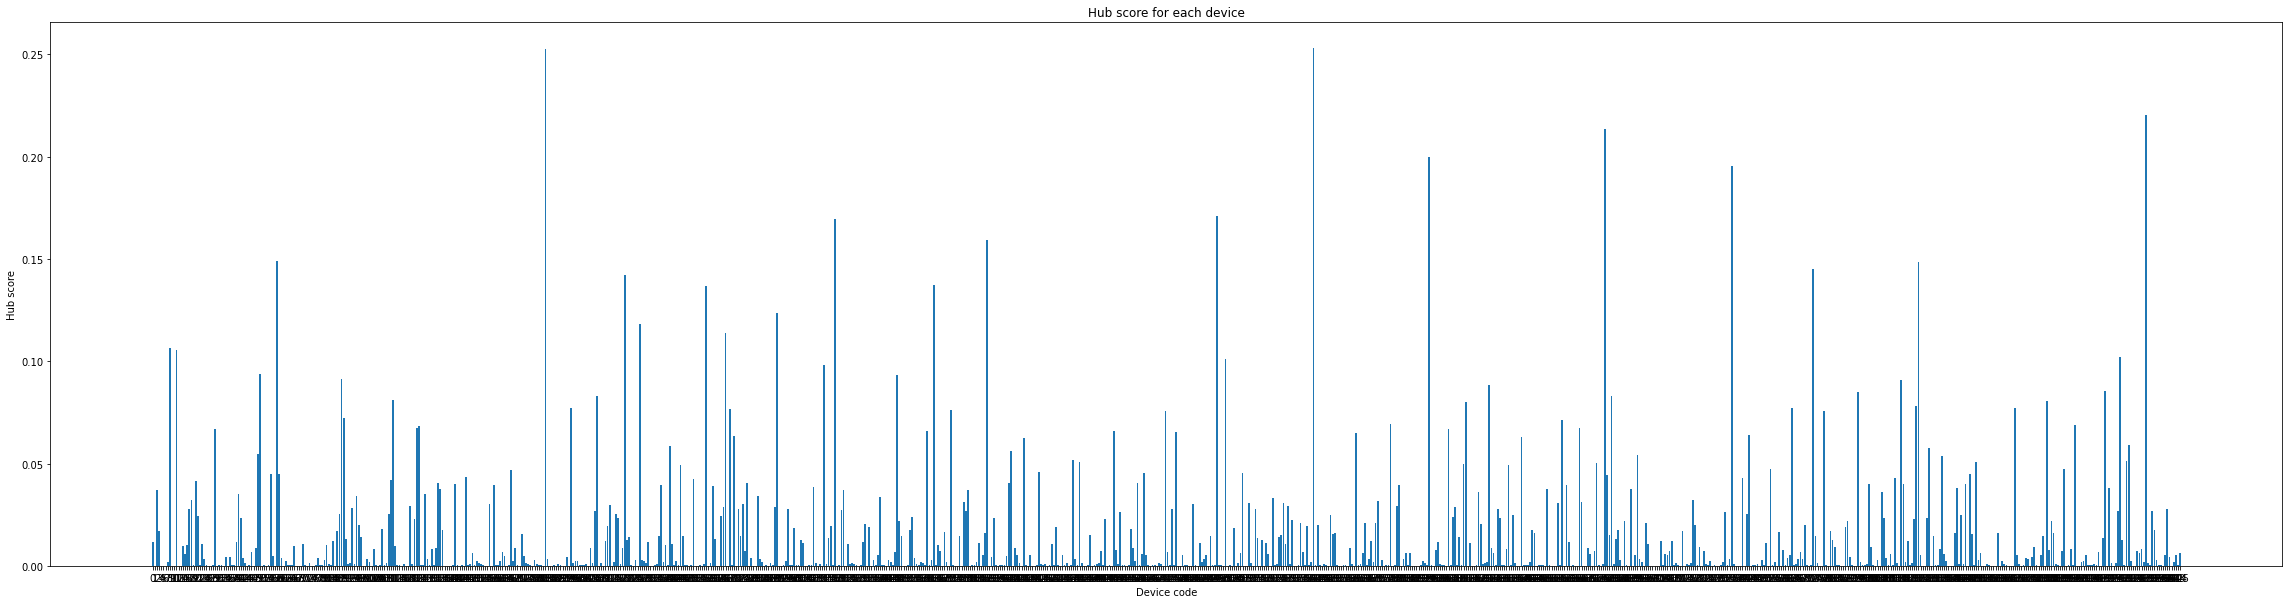

In [78]:
# plot hub scores

plt.figure(figsize=(40, 10))


plt.bar(np.arange(946), hubs)
plt.xticks(np.arange(0, 946, 1))
plt.xlabel('Device code')
plt.ylabel('Hub score')
plt.title('Hub score for each device')
plt.show()